# Setup

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from MetabolomicsPaper.GeneralHelperFunctions import *
from ACSPaper.ACSPaperUtils import *
from sklearn.metrics import roc_curve, auc
import shap
from sklearn.model_selection import train_test_split

paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Cardio/ACS_study/v2/'
curr_dir = os.path.join(paper_dir, 'serum_metabolomics_signatures')
make_dir_if_not_exists(curr_dir)
metabolon_dir = os.path.join(curr_dir, 'metabolon')
make_dir_if_not_exists(metabolon_dir)
nigtingale_dir = os.path.join(curr_dir, 'nigtingale')
make_dir_if_not_exists(nigtingale_dir)
os.chdir(paper_dir)

In [4]:
from LabData.DataLoaders.MetabolonLoader import MetabolonLoader

# Functions

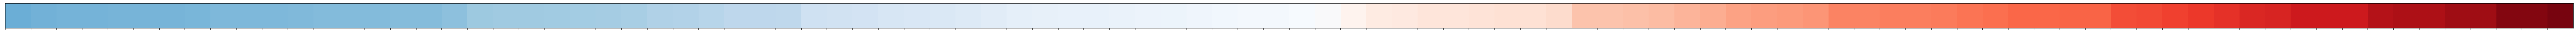

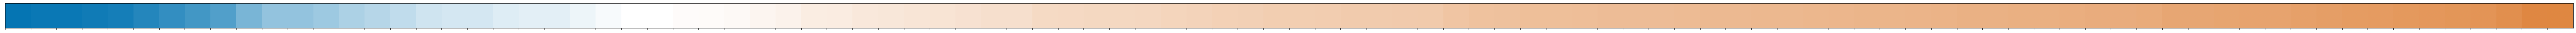

In [4]:
from matplotlib.colors import Normalize

def change_index(data, df, from_idx, to_idx):
    c_name = data.columns.names
    data = data.reset_index().merge(df.reset_index()[[from_idx, to_idx]], on=from_idx).set_index(to_idx).copy()
    del data[from_idx]
    data = data.loc[data.index.notnull()]
    data.columns.names = c_name
    return data

def _get_scale_colors(cmaps, data, zero_is_middle=True, base_n=300, boundries=None, return_cmap=False):
    if boundries is None:
        data_plus_min = data - min(0, data.min())
        data_plus_min /= data_plus_min.max()
        min_max_ratio = abs(data.min() / float(data.max()))
    else:
        data_plus_min = data + abs(boundries[0])
        data_plus_min /= (abs(boundries[0]) + boundries[1])
        min_max_ratio = abs(boundries[0] / float(boundries[1]))
    if len(cmaps) == 1:
        return [cmaps[0](i) for i in data_plus_min]

    colors1 = cmaps[0](np.linspace(0., 1, int(base_n*min_max_ratio)))
    colors2 = cmaps[1](np.linspace(0., 1, base_n))
    # combine them and build a new colormap
    colors = np.vstack((colors1, colors2))
    mymap = mcolors.LinearSegmentedColormap.from_list('my_colormap', colors)
    if return_cmap:
        return mymap
    return [mymap(i) for i in data_plus_min]

class MidpointNormalize(Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a
        # simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

sns.palplot(_get_scale_colors([plt.cm.Blues_r, plt.cm.Reds], np.sort(np.random.uniform(-0.5, 0.5, 100)), boundries=[-1, 0.5] ))

from matplotlib.colors import LinearSegmentedColormap
cm_acs = LinearSegmentedColormap.from_list('acs', ['white', acs_color], N=1000)
cm_healthy = LinearSegmentedColormap.from_list('healthy', [healthy_color, 'white'], N=1000)
sns.palplot(_get_scale_colors([cm_healthy, cm_acs], np.sort(np.random.uniform(-10, 30, 100)), boundries=[-10, 40] ))

# Load data

In [5]:
acs_data = pd.read_csv('data/ACS_full_data.csv', index_col=0)
pnp_data = pd.read_csv('data/pnp1_full_data.csv', index_col='RegistrationCode')
# pnp_data = pnp_data[pnp_data.IsGenotek == 0]
acs_data['ACS sample'], pnp_data['ACS sample'] = 1, 0

pnp_data.index = pnp_data.index.astype(str)
acs_data.index = acs_data.index.astype(str)

Columns (43) have mixed types.Specify dtype option on import or set low_memory=False.


In [6]:
metabolomics_paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/'

mar17_clinical_data = pd.read_csv(os.path.join(metabolomics_paper_dir, 'Paper_v4', 'dataframes', 'mar17_clinical_data.csv'), index_col=0)
mar17_stool_info = pd.read_csv(os.path.join(metabolomics_paper_dir, 'Paper_v4', 'dataframes', 'mar17_stool_info.csv'), index_col=0)
mar17_clinical_data = mar17_clinical_data.merge(mar17_stool_info[['FD_SPID', 'RegistrationCode']], on='FD_SPID')
mar17_clinical_data['RegistrationCode'] = mar17_clinical_data['RegistrationCode'].astype(str)

cardiac_risk_factors = ['Age', 'Gender', 'Waist', 'WHR', 'BMI', 'Hips', 'systolic', 'diastolic', 'bt__hba1c', 'smoke_tobacco_now', 'ever_smoked']
mar17_traditional_cardiac_risk_factors = mar17_clinical_data.merge(pnp_data[['bt__hba1c', 'smoke_tobacco_now', 'ever_smoked']], on='RegistrationCode', how='left').set_index('FD_SPID')[cardiac_risk_factors]
mar17_traditional_cardiac_risk_factors['bt__hba1c>6.4'] = [int(s>6.4) if not np.isnan(s) else s for s in mar17_traditional_cardiac_risk_factors['bt__hba1c']]
mar17_traditional_cardiac_risk_factors['6.4>=bt__hba1c>=5.7'] = [int((s>=5.7) & (s<=6.4)) if not np.isnan(s) else s for s in mar17_traditional_cardiac_risk_factors['bt__hba1c']]
mar17_traditional_cardiac_risk_factors['bt__hba1c<5.7'] = [int(s<5.7) if not np.isnan(s) else s for s in mar17_traditional_cardiac_risk_factors['bt__hba1c']]
mar17_traditional_cardiac_risk_factors = mar17_traditional_cardiac_risk_factors.drop('bt__hba1c', axis=1)

mar17_traditional_cardiac_risk_factors.astype(float).to_csv(os.path.join(paper_dir, 'data', 'mar17_traditional_cardiac_risk_factors.csv'))

## metabolon

In [5]:
metabolon = MetabolonLoader().get_data(study_ids=['PNP1', 'Cardio'], metabolon_runs=['Metabolon_MAR2017', 'Metabolon_MAY2018'],
                                       robust_zs=True, clip_outliers_std=5, clip_outliers_or_na='clip', fill_missing_with_min=True, 
                                       log_transform_base=10, norm_within_run_using_anchors=None, norm_across_run_using_anchors=True, 
                                       normalize_std=True)

In [13]:
metabolon.df_metadata.sort_index(inplace=True)
metabolon.df.sort_index(inplace=True)
metabolon_df = metabolon.df.reset_index().copy()
metabolon_df.loc[:, 'RegistrationCode'] = metabolon.df_metadata['RegistrationCode'].values
metabolon_df.loc[:, 'Date'] = metabolon.df_metadata['StorageDT'].values
# metabolon_df['metabolon_run'] = metabolon.df_metadata['metabolon_run'].values
# metabolon_df['StudyTypeID'] = metabolon.df_metadata['StudyTypeID'].values
metabolon_df = metabolon_df.groupby('RegistrationCode').first().reset_index()
metabolon_df.set_index(['RegistrationCode', 'Date'], inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [10]:
# metabolon_df = pd.read_csv(os.path.join(paper_dir, 'data', 'metabolon_df.csv'), index_col=['RegistrationCode', 'Date'], parse_dates=['Date']).drop('SerumName', axis=1)
# metabolon_df

,,100000007,100000008,100000010,100000011,100000014,100000015,100000016,100000036,100000039,100000042,...,X - 24809,X - 24811,X - 24812,X - 24813,X - 24849,X - 24947,X - 24949,X - 24951,X - 24952,X - 24972
RegistrationCode,Date,,,,,,,,,,,,,,,,,,,,,
10260,2015-05-20 17:59:23,-0.069397,-0.748087,-1.647513,-3.085304,-0.520353,0.753298,0.412713,0.212926,-0.093947,0.013640,...,0.524597,0.627937,-1.020288,-0.902961,-1.878970,0.244214,-3.027564,-0.012813,-0.404641,-1.184530
103543,2013-12-20 00:00:00,-1.218440,-0.303294,0.208652,0.621855,-0.267566,-0.643510,-0.215765,-1.853058,-1.325425,-2.233664,...,-1.541339,2.609569,0.494150,1.138546,-0.263386,0.223472,-0.152297,0.102358,0.093733,0.264814
105043,2014-05-07 00:00:00,1.701191,-1.149605,-0.465417,-1.281662,-0.794862,-0.497555,-1.842028,0.988773,-2.245467,0.143136,...,-0.416754,-3.061334,1.201751,1.531972,0.158380,-1.751377,2.016745,0.170450,-0.405440,-0.356527
107014,2014-08-31 00:00:00,0.135754,-1.618839,0.391476,0.849874,0.342135,1.132427,-0.538086,0.833777,0.064895,1.155616,...,-1.440946,-1.810028,-0.426800,0.969789,-0.288561,0.140361,-1.646495,-0.778571,-0.001870,-0.695831
109179,2014-03-05 00:00:00,-0.163607,0.732945,0.216269,0.635992,1.526667,1.377273,-0.233790,0.328840,0.801940,1.165586,...,-0.156977,0.106518,-2.280300,-1.099883,-1.063044,0.344381,-1.360070,-0.318137,-0.943141,-2.565434
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985783,2014-02-16 10:00:00,-0.790481,-1.424013,1.366861,1.550473,1.026477,0.262686,-0.479888,1.106487,-1.329015,1.298742,...,-0.619003,-0.247664,-0.907673,-1.041439,0.625639,2.051663,-1.476030,0.580380,0.268261,1.997251
987069,2014-07-02 00:00:00,-1.556095,-0.167095,1.629949,1.256573,1.049284,0.707396,0.841606,-0.385985,0.689650,0.576334,...,1.493540,1.078944,-1.176005,0.881184,-1.072558,-0.632580,0.339689,-1.213531,1.851749,-0.417291
990858,2014-09-17 00:00:00,0.592668,0.477269,1.418175,1.736364,1.031843,-3.274176,0.307738,-2.001571,0.031579,-2.644394,...,-1.718404,-0.430739,-1.193967,-0.142635,-1.076462,0.626092,-1.110430,-0.946369,0.110207,0.711327


In [546]:
updated_metabs1.loc[metabolon.df.columns].to_csv(os.path.join(curr_dir, '961_metabolon_metabolites.csv'))

In [117]:
# metabolon_metabolite_name_dic = metabolon.metabolites['BIOCHEMICAL'].to_dict()
# metabolon_metabolite_name_dic

{'100000007': 'carnitine',
 '100000008': 'benzoate',
 '100000010': '3-phenylpropionate (hydrocinnamate)',
 '100000011': 'phenylacetate',
 '100000014': 'hippurate',
 '100000015': 'xanthurenate',
 '100000016': 'suberate (C8-DC)',
 '100000036': '3-methyl-2-oxovalerate',
 '100000039': 'methionine sulfoxide',
 '100000042': '3-methylhistidine',
 '100000043': '4-acetamidophenylglucuronide',
 '100000054': '5-hydroxylysine',
 '100000096': '4-guanidinobutanoate',
 '100000135': "2'-deoxyinosine",
 '100000257': 'glucuronate',
 '100000258': 'glycerol 3-phosphate',
 '100000263': 'imidazole lactate',
 '100000265': 'kynurenine',
 '100000269': 'glycerophosphorylcholine (GPC)',
 '100000282': 'N-acetylglutamate',
 '100000285': 'N-alpha-acetylornithine',
 '100000295': 'tartarate',
 '100000299': 'xanthosine',
 '100000406': 'ribitol',
 '100000409': '2-isopropylmalate',
 '100000436': 'glycodeoxycholate',
 '100000437': 'theophylline',
 '100000442': 'quinate',
 '100000445': 'theobromine',
 '100000447': 'gentis

In [16]:
updated_metabs1 = pd.read_csv('/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/Paper_v4/dataframes/updated_metabs1.csv', index_col=0)
updated_metabs1['SUPER_PATHWAY'] = updated_metabs1['SUPER_PATHWAY'].fillna('Unknowns')
updated_metabs1['SUB_PATHWAY'] = updated_metabs1['SUB_PATHWAY'].fillna('Unknowns')

metabolon_metabolite_name_dic = updated_metabs1['BIOCHEMICAL'].to_dict()
metabolon_metabolite_super_pathway_dic = updated_metabs1['SUPER_PATHWAY'].to_dict()
metabolon_metabolite_sub_pathway_dic = updated_metabs1['SUB_PATHWAY'].to_dict()
metabolon_metabolite_name_dic

{'100016038': '(N(1) + N(8))-acetylspermidine',
 '100006373': '1,2,3-benzenetriol sulfate (1)',
 '100006374': '1,2,3-benzenetriol sulfate (2)',
 '100008903': '1,2-dilinoleoyl-GPC (18:2/18:2)',
 '100009217': '1,2-dilinoleoyl-GPE (18:2/18:2)*',
 '100000657': '1,2-dipalmitoyl-GPC (16:0/16:0)',
 '100001397': '1,3,7-trimethylurate',
 '100001106': '1,3-dimethylurate',
 '100000580': '1,5-anhydroglucitol (1,5-AG)',
 '100001399': '1,7-dimethylurate',
 '100005372': '1-(1-enyl-oleoyl)-GPE (P-18:1)*',
 '100009014': '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPC (P-16:0/20:4)*',
 '100009002': '1-(1-enyl-palmitoyl)-2-arachidonoyl-GPE (P-16:0/20:4)*',
 '100009009': '1-(1-enyl-palmitoyl)-2-linoleoyl-GPC (P-16:0/18:2)*',
 '100009069': '1-(1-enyl-palmitoyl)-2-linoleoyl-GPE (P-16:0/18:2)*',
 '100009007': '1-(1-enyl-palmitoyl)-2-oleoyl-GPC (P-16:0/18:1)*',
 '100009005': '1-(1-enyl-palmitoyl)-2-oleoyl-GPE (P-16:0/18:1)*',
 '100009160': '1-(1-enyl-palmitoyl)-2-palmitoleoyl-GPC (P-16:0/16:1)*',
 '100009162': '1-(1

In [17]:
with open(os.path.join(paper_dir, 'metabolon_molecules_to_remove.pkl'), 'rb') as handle:
    metabolon_molecules_to_remove = pickle.load(handle)

In [18]:
storage_bad_metabs = pd.read_pickle(os.path.join('../data', 'storage_time_bad_metabs_bonf.pkl'))

In [590]:
pnp_data_metabolon.dropna(subset=['X - 24809']).to_csv(os.path.join(curr_dir, 'pnp_data_metabolon.csv'))
acs_data_metabolon.dropna(subset=['X - 24809']).to_csv(os.path.join(curr_dir, 'acs_data_metabolon.csv'))

In [2]:
pnp_data_metabolon = pd.read_csv(os.path.join(curr_dir, 'pnp_data_metabolon.csv'))
pnp_data_metabolon['RegistrationCode'] = pnp_data_metabolon['RegistrationCode'].astype(str)
pnp_data_metabolon.set_index(['RegistrationCode'], inplace=True)
acs_data_metabolon = pd.read_csv(os.path.join(curr_dir, 'acs_data_metabolon.csv'))
acs_data_metabolon['RegistrationCode'] = acs_data_metabolon['RegistrationCode'].astype(str)
acs_data_metabolon.set_index(['RegistrationCode'], inplace=True)

data = pd.concat((pnp_data_metabolon, acs_data_metabolon), axis=0, sort=False)
print (data.shape)

Columns (43,3261,3277) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (10,23,30,33,40,96,97,101,107,110,111,112,131,132,133,134,135,136,137,138,139,140,141,142,143,145,148,149,150,151,152,153,155,157,159,169,170,179,184) have mixed types.Specify dtype option on import or set low_memory=False.


(630, 4681)


## metabolon r2 values

In [28]:
r2_col = 'Coefficient_of_determination'

metabolomics_paper_dir = '/net/mraid08/export/jafar/Microbiome/Analyses/Noamba/Metabolon/'
r2_results_dir = os.path.join(metabolomics_paper_dir, 'technical_noise/RSCV/LightGBM/')
mb_r2 = pd.read_csv(os.path.join(r2_results_dir, 'metabolomics_MB_daphna_LONG5_S/results.csv'), index_col=0)[[r2_col]].rename(columns={r2_col: 'Microbiome r2'})
diet_r2 = pd.read_csv(os.path.join(r2_results_dir, 'metabolomics_ffq+diet0.05/results.csv'), index_col=0)[[r2_col]].rename(columns={r2_col: 'Diet r2'})
clinical_r2 = pd.read_csv(os.path.join(r2_results_dir, 'metabolomics_clinical_data/results.csv'), index_col=0)[[r2_col]].rename(columns={r2_col: 'Clinical r2'})
trf_r2 = pd.read_csv(os.path.join(r2_results_dir, 'metabolomics_traditional_cardiac_risk_factors//results.csv'), index_col=0)[[r2_col]].rename(columns={r2_col: 'Traditional Risk Factors r2'})
genetics_r2 = pd.read_csv(os.path.join(metabolomics_paper_dir, 'Genetics', 'CVPrediction', 'single', 'results.csv'), index_col=0)[[r2_col]].rename(columns={r2_col: 'Genetics r2'})

r2_df = pd.concat((mb_r2, diet_r2, trf_r2, genetics_r2), axis=1, sort=False).clip(lower=0, upper=0.3)

# Diabetes enrichment

## logit

In [135]:
acs_data_metabolon.loc[:, 'DM'] = (acs_data_metabolon.loc[:, 'Glucose Disorder: DM1']==1) | \
                                                                (acs_data_metabolon.loc[:, 'Glucose Disorder: DM2']==1) | \
                                                                (acs_data_metabolon.loc[:, 'HbA1C']>6.4)

dm_acs = acs_data_metabolon.dropna(subset=['100000010'])[acs_data_metabolon['DM']==1].index.astype(str)
nondm_acs = acs_data_metabolon.dropna(subset=['100000010'])[acs_data_metabolon['DM']==0].index.astype(str)

In [156]:
y = 'DM'
acs_data_metabolon['const'] = 1
covariates = ['Age', 'gender', 'const', 'bmi']
use_covariates = True
cols = metabolon.df.columns
samples = dm_acs.tolist() + nondm_acs.tolist()

# pvals = pd.DataFrame(np.nan, index=cols, columns=['unmatched Logit', 'matched Logit'])
logs = pd.DataFrame(index=cols, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=cols, columns=['Logit ' + c for c in columns])

for col in tqdm_notebook(cols):
    if covariates:
        try:
            log = Logit(acs_data_metabolon.loc[samples, y].astype(float), 
                                    acs_data_metabolon.loc[samples, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[col, 'Logit coef'] = log.params.loc[col]#np.exp(log.params.loc[col])
            logit_results.loc[col, 'Logit pval'] = log.pvalues.loc[col]
            logit_results.loc[col, 'Logit 0.025'], logit_results.loc[col, 'Logit 0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[col, 'Logit log'] = log
        except:
            pass
    else:
        pass
logit_results_dm = logit_results.dropna()
logit_results_dm['directional pval'] = logit_results_dm.apply(lambda x: np.log10(x['Logit pval']) * -np.sign(x['Logit coef']), axis=1)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals


# MMC no HPN + Dyslipidemia

In [6]:
mmc = pd.read_csv(os.path.join(paper_dir, 'Matching/PNP1-ACS_matching/', 'PNP1-ACS_metabolon_age+sex+bmi+DM+smoking_1:1.csv'), index_col=0)
mmc_pnp = mmc[mmc['ACS sample']==0].index.astype(str)
mmc_acs = mmc[mmc['ACS sample']==1].index.astype(str)

In [23]:
data.loc[mmc_pnp.tolist()+mmc_acs.tolist(), ['ACS sample', 'Age', 'gender', 'bmi'] + metabolon.df.columns.tolist()].to_csv(os.path.join(curr_dir, 'PNP83-ACS83_matched_metabolon_data.csv'))

In [133]:
y = 'ACS sample'
data['const'] = 1
covariates = ['Age', 'gender', 'const']
use_covariates = True
cols = metabolon.df.columns
samples = mmc_pnp.tolist() + mmc_acs.tolist()

# pvals = pd.DataFrame(np.nan, index=cols, columns=['unmatched Logit', 'matched Logit'])
logs = pd.DataFrame(index=cols, columns=['Logit'])
columns = ['coef', 'pval', '0.025', '0.975', 'log']
logit_results = pd.DataFrame(index=cols, columns=['Logit ' + c for c in columns])

for col in tqdm_notebook(cols):
    if covariates:
        try:
            log = Logit(data.loc[samples, y].astype(float), 
                                    data.loc[samples, [col] + covariates], missing='drop').fit(disp=0)
            logit_results.loc[col, 'Logit coef'] = log.params.loc[col]#np.exp(log.params.loc[col])
            logit_results.loc[col, 'Logit pval'] = log.pvalues.loc[col]
            logit_results.loc[col, 'Logit 0.025'], logit_results.loc[col, 'Logit 0.975'] = log.conf_int().loc[col].apply(np.exp).values
            logit_results.loc[col, 'Logit log'] = log
        except:
            pass
    else:
        pass
logit_results_mmc_no_hpn = logit_results.dropna()
logit_results_mmc_no_hpn['directional pval'] = logit_results_mmc_no_hpn.apply(lambda x: np.log10(x['Logit pval']) * -np.sign(x['Logit coef']), axis=1)

This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


Maximum Likelihood optimization failed to converge. Check mle_retvals
Maximum Likelihood optimization failed to converge. Check mle_retvals
overflow encountered in exp
divide by zero encountered in log



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [157]:
circ_heatmap_df_sorted = pd.concat((logit_results_mmc_no_hpn['directional pval'].rename('Healthy-ACS'), 
                                                            logit_results_dm['directional pval'].rename('DM-ACS'), 
                                                            r2_df), axis=1).dropna().sort_values('Healthy-ACS')
circ_heatmap_df_sorted['SUPER_PATHWAY'] = circ_heatmap_df_sorted.rename(index=metabolon_metabolite_super_pathway_dic).index
circ_heatmap_df_sorted = circ_heatmap_df_sorted.sort_values(['SUPER_PATHWAY', 'Healthy-ACS']).drop('SUPER_PATHWAY', axis=1)
circ_heatmap_df_sorted.to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'))
circ_heatmap_df_sorted

,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
100020427,-10.155976,2.549957,0.009726,0.000000,0.119565,0.000000
100004523,-9.490470,-0.012484,0.036805,0.200714,0.005265,0.141974
100004056,-8.740516,0.491537,0.049153,0.120917,0.000000,0.000000
100000096,-8.104182,-0.063893,0.000000,0.025331,0.022601,0.000000
100006361,-8.087391,1.072853,0.000325,0.006318,0.013639,0.000000
...,...,...,...,...,...,...
100009232,3.990272,-0.802307,0.002318,0.000000,0.000000,0.000000
100000445,5.226085,-0.476963,0.072204,0.114427,0.006118,0.000000
501,9.791267,-0.512215,0.000000,0.012121,0.001731,0.000000
1869,10.550857,-1.051021,0.005118,0.017169,0.027414,0.000000


In [158]:
saved_metab_enrich = logit_results_mmc_no_hpn.rename(index=metabolon_metabolite_name_dic).sort_values('Logit pval').drop('Logit log', axis=1)
saved_metab_enrich['Enriched in ACS'] = saved_metab_enrich['directional pval'] > 0
saved_metab_enrich['Logit qval'] = fdr_correction(saved_metab_enrich['Logit pval'])[1]
saved_metab_enrich.to_csv(os.path.join(metabolon_dir, 'metabolon_enrichments_MMC_no_HPN+DYS.csv'))

## comparing LDL levels

Text(0.5, 1.0, 'MWU P-value=0.4')

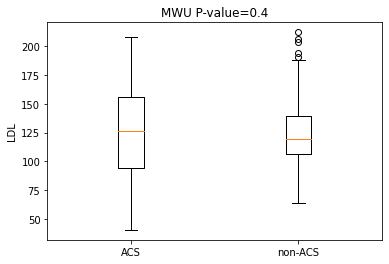

In [126]:
c = 'LDL_nightingale_friedewald'
t, p = mannwhitneyu(data.loc[mmc_acs, c].dropna(), data.loc[mmc_pnp, c].dropna())
plt.boxplot([data.loc[mmc_acs, c].dropna(), data.loc[mmc_pnp, c].dropna()], labels=['ACS', 'non-ACS'])
plt.ylabel('LDL')
plt.title('MWU P-value=%0.1g'%p)

# Plot - merge with microbiome

## main figure

In [163]:
circ_heatmap_df_sorted = pd.read_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0).astype(float)
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]
circ_heatmap_df_sorted

,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
100020427,-10.155976,2.549957,0.009726,0.000000,0.119565,0.000000
100004523,-9.490470,-0.012484,0.036805,0.200714,0.005265,0.141974
100004056,-8.740516,0.491537,0.049153,0.120917,0.000000,0.000000
100000096,-8.104182,-0.063893,0.000000,0.025331,0.022601,0.000000
100006361,-8.087391,1.072853,0.000325,0.006318,0.013639,0.000000
...,...,...,...,...,...,...
100009232,3.990272,-0.802307,0.002318,0.000000,0.000000,0.000000
100000445,5.226085,-0.476963,0.072204,0.114427,0.006118,0.000000
501,9.791267,-0.512215,0.000000,0.012121,0.001731,0.000000
1869,10.550857,-1.051021,0.005118,0.017169,0.027414,0.000000


In [164]:
fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)), alpha=0.1)[0].sum()

517

FixedFormatter should only be used together with FixedLocator
This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


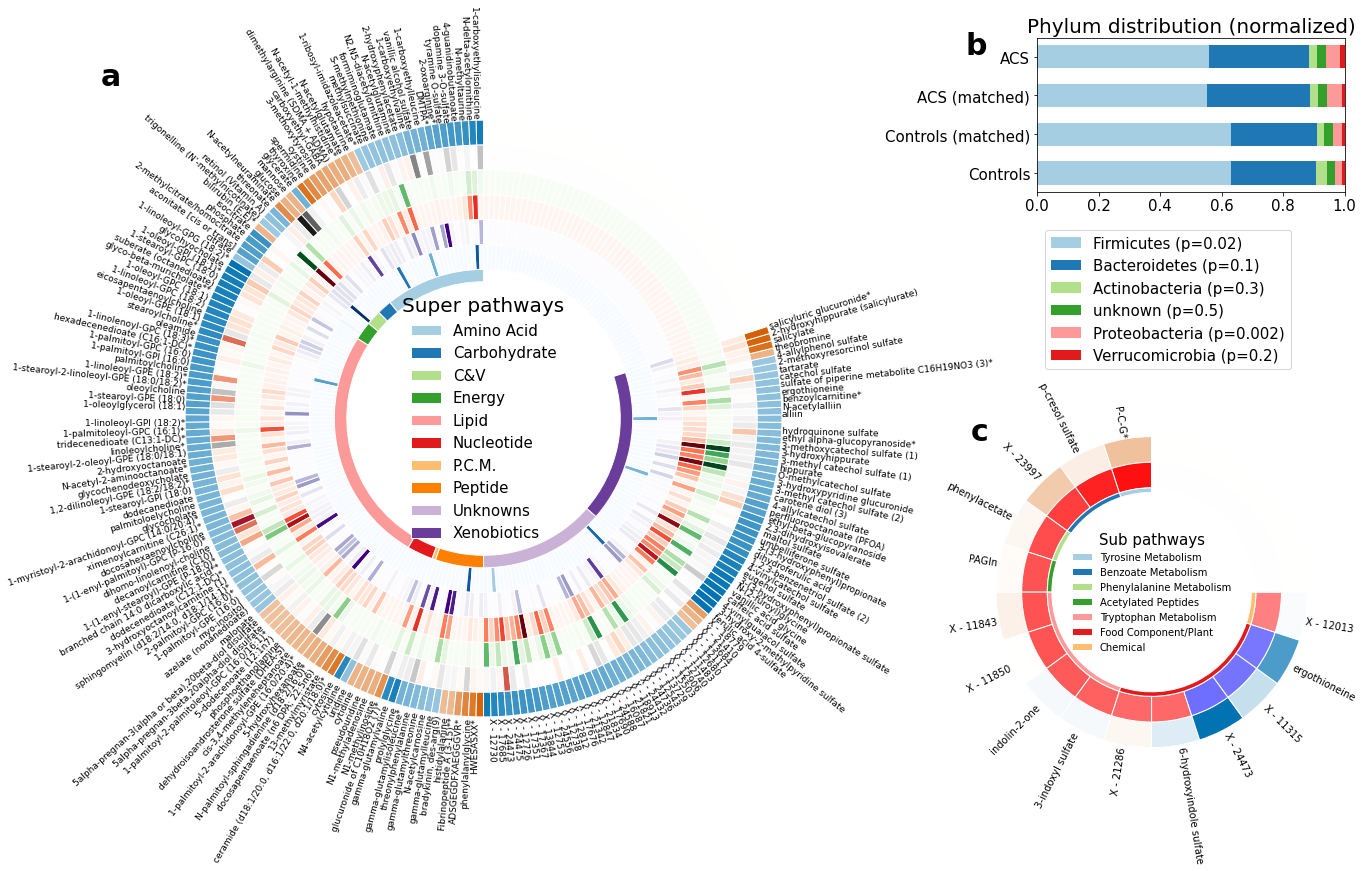

In [171]:
circ_heatmap_df_sorted = pd.read_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0).astype(float)
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]
# bonferonni 0.05
# df = circ_heatmap_df_sorted.loc[circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)) < 0.05/circ_heatmap_df_sorted.shape[0]]
# FDR 10%
df = circ_heatmap_df_sorted.loc[(fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)))[1] < 0.1)]

df.to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_MMC_no_HPN_DYS-DM.csv'))

df = df[df.index.isin(circ_heatmap_df_sorted.abs().sort_values('Healthy-ACS').tail(200).index)]

df = pd.concat((df, pd.DataFrame(0, index=['']*int(df.shape[0]*0.25), columns=df.columns)), axis=0, sort=False)

super_pathway_names = df.rename(index=metabolon_metabolite_super_pathway_dic).index.unique().values.tolist()
group_size=[df.rename(index=metabolon_metabolite_super_pathway_dic).index.value_counts().loc[i] for i in super_pathway_names]
 
cmaps = {'Healthy-ACS':[cm_healthy, cm_acs], 'DM-ACS':[plt.cm.RdGy],
                 'Microbiome r2':[plt.cm.Greens], 'Diet r2':[plt.cm.Reds], 'Genetics r2':[plt.cm.Blues], 'Traditional Risk Factors r2':[plt.cm.Purples]}
boundries = {k:None for k in cmaps}
boundries['Healthy-ACS'] = (-11, 11)
boundries['DM-ACS'] = (-7, 7)
 
    
fig = plt.figure(figsize=(21, 14))
gs = gridspec.GridSpec(9, 15, wspace=.1, hspace=0.3)

circ_ax = fig.add_subplot(gs[:, :8])
taxa_ax = fig.add_subplot(gs[:2, 11:])
sgb_ax = fig.add_subplot(gs[5:8, 11:14])

label_fontsize=20
tick_fontsize=15


ax = circ_ax
radius = 1.2
radius_step = 0.1

for layer in df.columns:
    if layer == 'Healthy-ACS':
        labels = df.rename(index=metabolon_metabolite_name_dic).rename(index={'2,3-dihydroxy-5-methylthio-4-pentenoate (DMTPA)*': 'DMTPA*'}).index
    else:
        labels = ['' for i in df.index]
    mypie2, texts = ax.pie([1 for i in range(df.shape[0])], radius=radius, labels=labels, rotatelabels=True,
                       labeldistance=1., textprops={'fontsize': 9},
                       colors=_get_scale_colors(cmaps[layer], df[layer], boundries=boundries[layer]), startangle=90)
    
    plt.setp(mypie2, width=radius_step, edgecolor='white')
    radius -= radius_step

mypie, _ = ax.pie(group_size, radius=radius,
                  colors=sns.color_palette('Paired', len(super_pathway_names))[:-1] + [(1, 1, 1)],
                  textprops=dict(color='black', fontsize=50), startangle=90)
plt.setp(mypie, width=0.05, edgecolor='white')

legend = ax.legend(mypie, [s.replace('Cofactors and Vitamins','C&V').replace('Partially Characterized Molecules', 'P.C.M.') for s in super_pathway_names][:-1], #super_pathway_names,
                                  title="Super pathways",
                                  loc="center",
                                  bbox_to_anchor=(0., 0, 1, 1.),
                                  fontsize=tick_fontsize, frameon=False)
legend.get_title().set_fontsize(str(label_fontsize))


ax = taxa_ax
with open(os.path.join(paper_dir, 'TaxaComposition', 'required_data_for_plot.pkl'), 'rb') as handle:
    required_data_for_plot = pickle.load(handle)
df_mean = required_data_for_plot['df_mean']
df_std = required_data_for_plot['df_std']

labels = ['Controls', 'Controls (matched)', 'ACS (matched)', 'ACS']
width=0.6

# paired_colors = sns.color_palette('Paired', df_mean.shape[0])
# for i, color in zip(range(df_mean.shape[0]), paired_colors):
#     label = df_mean.index[i]
#     if i == 0:
#         ax.bar(labels, df_mean.loc[label], width, label=label, color=color) #  yerr=df_std.loc[label]
#     else:
#         ax.bar(labels, df_mean.loc[label], width, label=label, bottom=df_mean.head(i).sum(), color=color)
# ax.tick_params(labelsize=tick_fontsize)
# ax.set_ylabel('Phylum distribution\n(normalized)', fontsize=label_fontsize)
# ax.set_xticklabels(labels, rotation=90)

# leg = ax.legend(ncol=1, loc='upper left' , bbox_to_anchor=(1, 1),
#                   fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='Phyla')
# leg.get_title().set_fontsize(str(label_fontsize))

matched_acs_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'matched_acs_mb_full_phyla.csv'), index_col=0)
matched_pnp_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'matched_pnp_mb_full_phyla.csv'), index_col=0)
acs_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'acs_mb_full_phyla.csv'), index_col=0)
pnp_mb_full_phyla = pd.read_csv(os.path.join(paper_dir, 'TaxaComposition', 'pnp_mb_full_phyla.csv'), index_col=0)

paired_colors = sns.color_palette('Paired', df_mean.shape[0])
for i, color in zip(range(df_mean.shape[0]), paired_colors):
    label = df_mean.index[i]
    t, p  = kruskal(matched_pnp_mb_full_phyla.loc[:, label].dropna(), matched_acs_mb_full_phyla.loc[:, label].dropna())
#     print (label + ' (p=%0.1g)'%(p))
    if i == 0:
        ax.barh(labels, df_mean.loc[label], width, label=label + ' (p=%0.1g)'%(p), color=color) #  yerr=df_std.loc[label]
    else:
        ax.barh(labels, df_mean.loc[label], width, label=label+ ' (p=%0.1g)'%(p), left=df_mean.head(i).sum(), color=color)
ax.tick_params(labelsize=tick_fontsize)
ax.set_title('Phylum distribution (normalized)', fontsize=label_fontsize)
ax.set_yticklabels(labels)
ax.set_xlim((0, 1))

leg = ax.legend(ncol=1, loc='upper left' , bbox_to_anchor=(0, -0.2),
                  fontsize=tick_fontsize, frameon=True, labelspacing=0.5, title='')
leg.get_title().set_fontsize(str(label_fontsize))


ax = sgb_ax
with open(os.path.join(paper_dir, 'specific_mb-metabolite_pathway', 'required_data_for_plot.pkl'), 'rb') as handle:
    required_data_for_plot = pickle.load(handle)

df = required_data_for_plot['df'].replace({'p-cresol-glucuronide*': 'P-C-G*', 'phenylacetylglutamine': 'PAGln'})
super_pathway_names = df['SUB_PATHWAY'].unique().tolist()
group_size=[df['SUB_PATHWAY'].value_counts().loc[i] for i in super_pathway_names]
 
cmaps = {'Healthy-ACS':[cm_healthy, cm_acs], 'Correlation with bacteria':[plt.cm.bwr_r]}
boundries = {k:None for k in cmaps}
boundries['Healthy-ACS'] = (-7, 7)
boundries['Correlation with bacteria'] = (-0.35, 0.35)

# ax.axis('equal')

radius = 1.7
radius_step = 0.28

for layer in df.columns:
    if layer == 'BIOCHEMICAL' or layer == 'SUB_PATHWAY':
        continue
    if layer == 'Healthy-ACS':
        labels = df['BIOCHEMICAL']
#         labels = df.index
    else:
        labels = ['' for i in df.index]
    mypie2, texts = ax.pie([1 for i in range(df.shape[0])], radius=radius, labels=labels, rotatelabels=True,
                       labeldistance=1.,
                       colors=_get_scale_colors(cmaps[layer], df[layer], boundries=boundries[layer]), startangle=90)

    
    plt.setp(mypie2, width=radius_step, edgecolor='white')
    radius -= radius_step

mypie, _ = ax.pie(group_size, radius=radius,
#                   colors=sns.color_palette('Paired', len(super_pathway_names)), 
                  colors=sns.color_palette('Paired', len(super_pathway_names))[:-1] + [(1, 1, 1)],
                  textprops=dict(color='black', fontsize=50), startangle=90)
plt.setp(mypie, width=0.05, edgecolor='white')

legend = ax.legend(mypie, super_pathway_names[:-1],
                                  title="Sub pathways",
                                  loc="center",
                                  bbox_to_anchor=(0., 0, 1, 1.),
                                  fontsize=10, frameon=False)
legend.get_title().set_fontsize('15')


fig.tight_layout()
plt.text(-0.1, 1.05, 'a', ha='center', va='center', transform=circ_ax.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.2, 0.95, 'b', ha='center', va='center', transform=taxa_ax.transAxes, fontsize=30, weight = 'bold')
plt.text(-0.25, 1.2, 'c', ha='center', va='center', transform=sgb_ax.transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Figure1.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Figure1.pdf'), dpi=300, bbox_inches='tight')

## metabolomics supplementary

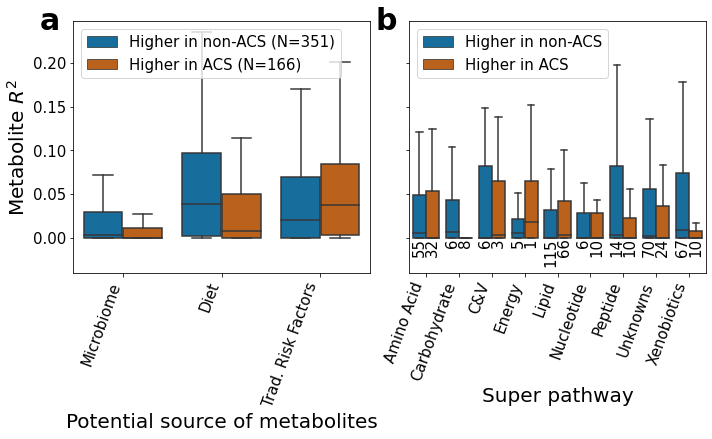

In [175]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True)

label_fontsize=20
tick_fontsize=15

circ_heatmap_df_sorted = pd.read_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0).astype(float)
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]
# bonferonni 0.05
# df = circ_heatmap_df_sorted.loc[circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)) < 0.05/circ_heatmap_df_sorted.shape[0]]
# FDR 10%
df = circ_heatmap_df_sorted.loc[(fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)))[1] < 0.1)]

df = pd.concat((df, pd.DataFrame(0, index=['']*int(df.shape[0]*0.25), columns=df.columns)), axis=0, sort=False)

# df.drop('').to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_MMC_no_HPN_DYS-DM.csv'))

super_pathway_names = df.rename(index=metabolon_metabolite_super_pathway_dic).index.unique().values.tolist()
group_size=[df.rename(index=metabolon_metabolite_super_pathway_dic).index.value_counts().loc[i] for i in super_pathway_names]

ax = axes[0]
melted_df = df.drop('').drop(['DM-ACS', 'Genetics r2'], axis=1).rename(columns={k:k.replace(' r2', '') for k in df.columns})\
                    .rename(columns={'Traditional Risk Factors': 'Trad. Risk Factors'}).melt(id_vars=['Healthy-ACS'])
melted_df['Healthy-ACS'] = melted_df['Healthy-ACS']>0
melted_df['Healthy-ACS'].replace({True:'Higher in ACS (N=%0.1d)'%((df['Healthy-ACS']>0).sum()), False:'Higher in non-ACS (N=%0.1d)'%((df['Healthy-ACS']<0).sum())}, inplace=True)
sns.boxplot(data=melted_df, x='variable', y='value', hue='Healthy-ACS', ax=ax, palette=[healthy_color, acs_color], showfliers=False)
ax.tick_params(labelsize=tick_fontsize)
ax.set_yticks([0, 0.05, 0.1, 0.15, 0.2])
ax.set_ylabel('Metabolite $R^2$', fontsize=label_fontsize)
ax.set_xlabel('Potential source of metabolites', fontsize=label_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.legend(title=None, fontsize=tick_fontsize)

ax = axes[1]
melted_df = df.drop('').drop('DM-ACS', axis=1).rename(index=metabolon_metabolite_super_pathway_dic).rename_axis('SUPER_PATHWAY').reset_index().melt(id_vars=['Healthy-ACS', 'SUPER_PATHWAY'])
melted_df['Healthy-ACS'] = melted_df['Healthy-ACS']>0
melted_df['Healthy-ACS'].replace({True:'Higher in ACS', False:'Higher in non-ACS'}, inplace=True)
melted_df['SUPER_PATHWAY'].replace({'Cofactors and Vitamins':'C&V', 'Partially Characterized Molecules':'P.C.M.'}, inplace=True)
sns.boxplot(data=melted_df[melted_df['SUPER_PATHWAY']!='P.C.M.'], x='SUPER_PATHWAY', y='value', hue='Healthy-ACS', ax=ax, palette=[healthy_color, acs_color], showfliers=False)
ax.set_ylim((-0.04, ax.get_ylim()[1]))
ax.tick_params(labelsize=tick_fontsize)
ax.set_ylabel('Metabolite $R^2$', fontsize=label_fontsize)
ax.set_ylabel('', fontsize=label_fontsize)
ax.set_xlabel('Super pathway', fontsize=label_fontsize)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70, ha='right')
ax.legend(title=None, fontsize=tick_fontsize, loc='upper left')

metab_counts = melted_df[melted_df['variable']=='Diet r2'].groupby(['SUPER_PATHWAY', 'Healthy-ACS']).apply(lambda x: x.shape[0])

for xtick, i in zip([s.get_text() for s in ax.get_xticklabels()], ax.get_xticks()):
    try:
        ax.text(i-0.2, 0, metab_counts.loc[(xtick, 'Higher in non-ACS')], rotation=90, ha='center', va='top', fontsize=tick_fontsize)
    except:
        pass
    try:
        ax.text(i+0.2, 0, metab_counts.loc[(xtick, 'Higher in ACS')], rotation=90, ha='center', va='top', fontsize=tick_fontsize)
    except:
        pass

fig.tight_layout()
plt.text(-0.08, 1., 'a', ha='center', va='center', transform=axes[0].transAxes, fontsize=30, weight = 'bold')
plt.text(-0.08, 1., 'b', ha='center', va='center', transform=axes[1].transAxes, fontsize=30, weight = 'bold')

plt.savefig(os.path.join(metabolon_dir, 'Extended_data_figure_metabolomics_boxplots.png'), dpi=300, bbox_inches='tight')
plt.savefig(os.path.join(metabolon_dir, 'Extended_data_figure_metabolomics_boxplots.pdf'), dpi=300, bbox_inches='tight')

### numbers

In [170]:
print ((df.drop('')['Healthy-ACS'] < 0).sum(), (df.drop('')['Healthy-ACS'] < 0).sum()/df.drop('').shape[0])
print (fdr_correction(df.drop('')['DM-ACS'].abs().apply(lambda x: 10**(-x)), alpha=0.1)[0].sum())
print ('Diet', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Diet r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Diet r2']))
print ('Microbiome', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Microbiome r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Microbiome r2']))
print ('Traditional Risk Factors', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Traditional Risk Factors r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Traditional Risk Factors r2']))
print ('Genetics', directed_mannwhitneyu(df.drop('')[df.drop('')['Healthy-ACS'] < 0]['Genetics r2'], df.drop('')[df.drop('')['Healthy-ACS'] > 0]['Genetics r2']))

351 0.6789168278529981
51
Diet (-21698.5, 1.043944386012166e-06)
Microbiome (-23631.5, 0.00010502658179976049)
Traditional Risk Factors (25524.0, 0.0109296453175684)
Genetics (27980.0, 0.07057304430751628)


In [603]:
df.drop('').sort_values('Microbiome r2', ascending=False).rename(index=metabolon_metabolite_name_dic).to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_by_Microbiome.csv'))
df.drop('').sort_values('Genetics r2', ascending=False).rename(index=metabolon_metabolite_name_dic).to_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_by_Genetics.csv'))

## color bars

Use the colorbar set_ticks() method instead.


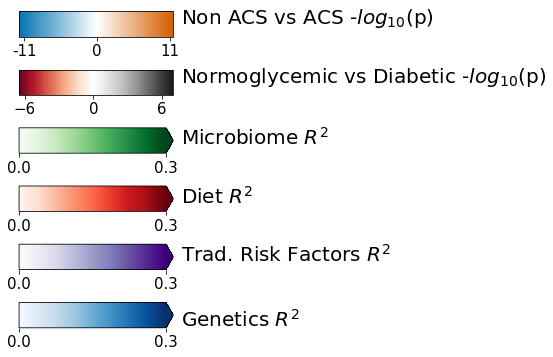

In [192]:
tick_fontsize = 15
label_fontsize = 15

fig, axes = plt.subplots(6, 1, figsize=(8, 5))

ax = axes[0]
norm1 = MidpointNormalize(vmin=df['Healthy-ACS'].min(), 
                          vmax=df['Healthy-ACS'].max(), 
                          midpoint=0)
cmap1 = _get_scale_colors([cm_healthy, cm_acs], df['Healthy-ACS'], return_cmap=True, boundries=[-11, 11])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap1,
                                norm=norm1, ticks=[-11, 0, 11], 
                                orientation='horizontal')
# cb1.set_label('Healthy-ACS ($log_{10}$ pvalue)', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)

cb1.ax.set_xticklabels([-11, 0, 11]) # [-20, 0, 20]
ax.text(df['Healthy-ACS'].max() * 1.1, 0.1, 'Non ACS vs ACS -$log_{10}$(p)', fontsize=label_fontsize+5)

ax = axes[1]
norm1 = MidpointNormalize(vmin=df['DM-ACS'].min(), 
                          vmax=df['DM-ACS'].max(), 
                          midpoint=0)
# cmap1 = _get_scale_colors([plt.cm.RdGy], df['Diabetes'], return_cmap=True, boundries=[-10, 10])
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.RdGy,
                                norm=norm1, ticks=[-6, 0, 6], 
                                orientation='horizontal')
# cb1.set_label('Healthy-ACS ($log_{10}$ pvalue)', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
# cb1.ax.set_xticklabels([-6, 0, 5]) 
cb1.ax.set_xticks([-6, 0, 6]) 
ax.text(df['DM-ACS'].max() * 1.1, 0.1, 'Normoglycemic vs Diabetic -$log_{10}$(p)', fontsize=label_fontsize+5)

ax = axes[2]
norm1 = mpl.colors.Normalize(vmin=0, 
                                                 vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Greens,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Microbiome $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.1, 0.1, 'Microbiome $R^2$', fontsize=label_fontsize+5)

ax = axes[3]
norm1 = mpl.colors.Normalize(vmin=0, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Reds,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Diet $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.1, 0.1, 'Diet $R^2$', fontsize=label_fontsize+5)

ax = axes[4]
norm1 = mpl.colors.Normalize(vmin=0, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Purples,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Genetics $R^2$', fontsize=label_fontsize)
cb1.ax.tick_params(labelsize=tick_fontsize)
cb1.ax.yaxis.label.set_size(label_fontsize)
ax.text(0.3 * 1.1, 0.1, 'Trad. Risk Factors $R^2$', fontsize=label_fontsize+5)

ax = axes[5]
norm1 = mpl.colors.Normalize(vmin=0, vmax=0.3)
cb1 = mpl.colorbar.ColorbarBase(ax, cmap=plt.cm.Blues,
                                norm=norm1, ticks=[0, 0.3], 
                                orientation='horizontal', extend='max')
# cb1.set_label('Clinical data $R^2$', fontsize=label_fontsize, labelpad=1)
cb1.ax.tick_params(labelsize=tick_fontsize)
# cb1.ax.set
cb1.ax.yaxis.label.set_size(label_fontsize)
# cb1.ax.xaxis.label.set_position((1, 1))
ax.text(0.3 * 1.1, 0.1, 'Genetics $R^2$', fontsize=label_fontsize+5, va='center')

fig.tight_layout()
plt.savefig(os.path.join(metabolon_dir, 'colorbars_v2.png'), dpi=300)
# plt.savefig(os.path.join(metabolon_dir, 'legend.png'), dpi=800)

# drug deconfounding results

In [196]:
ddp_dir = os.path.join('../drug_deconfounding_pipeline')
os.listdir(ddp_dir)

['output_metabolome_20201026.r.filtered',
 'microbiome_significant.csv',
 '.ipynb_checkpoints',
 'metabolon_significant.csv',
 'output_microbiome_20201026.r.filtered']

In [203]:
metabolon_res = pd.read_csv(os.path.join(ddp_dir, 'output_metabolome_20201026.r.filtered'), sep='\t', header=None)
metabolon_res[1] = [s.replace('X', '').replace('...', 'X - ') for s in metabolon_res[1]]
metabolon_res.set_index(1, inplace=True)
metabolon_res[5].value_counts()

SD                                                                                                                                         363
gender                                                                                                                                      53
LD                                                                                                                                          45
Age                                                                                                                                         39
NC                                                                                                                                          21
                                                                                                                                          ... 
Age, DM, Hypertension, Statin.intake, Sulfonylurea.intake, Aspirine.intake, Beta.blocker.intake, GLP.1.agonist.intake, Metformin.intake      1

In [208]:
circ_heatmap_df_sorted = pd.read_csv(os.path.join(metabolon_dir, 'circ_heatmap_df_sorted_MMC_no_HPN_DYS-DM.csv'), index_col=0).astype(float)
circ_heatmap_df_sorted = circ_heatmap_df_sorted[~circ_heatmap_df_sorted.index.isin(storage_bad_metabs)]
# bonferonni 0.05
# df = circ_heatmap_df_sorted.loc[circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)) < 0.05/circ_heatmap_df_sorted.shape[0]]
# FDR 10%
circ_heatmap_df_sorted_fdr01 = circ_heatmap_df_sorted.loc[(fdr_correction(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x)))[1] < 0.1)]
# circ_heatmap_df_sorted_fdr01 = circ_heatmap_df_sorted.loc[(circ_heatmap_df_sorted['Healthy-ACS'].abs().apply(lambda x: 10**(-x) < 0.05/893))]

In [209]:
circ_heatmap_df_sorted_fdr01

,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2
100020427,-10.155976,2.549957,0.009726,0.000000,0.119565,0.000000
100004523,-9.490470,-0.012484,0.036805,0.200714,0.005265,0.141974
100004056,-8.740516,0.491537,0.049153,0.120917,0.000000,0.000000
100000096,-8.104182,-0.063893,0.000000,0.025331,0.022601,0.000000
100006361,-8.087391,1.072853,0.000325,0.006318,0.013639,0.000000
...,...,...,...,...,...,...
100009232,3.990272,-0.802307,0.002318,0.000000,0.000000,0.000000
100000445,5.226085,-0.476963,0.072204,0.114427,0.006118,0.000000
501,9.791267,-0.512215,0.000000,0.012121,0.001731,0.000000
1869,10.550857,-1.051021,0.005118,0.017169,0.027414,0.000000


In [210]:
df = pd.concat((circ_heatmap_df_sorted_fdr01, metabolon_res), axis=1).dropna(subset=['Healthy-ACS'])
df[~df[5].isin(['NC', 'SD', 'LD'])].dropna(subset=[0, 2, 3, 4, 5])

,Healthy-ACS,DM-ACS,Microbiome r2,Diet r2,Traditional Risk Factors r2,Genetics r2,0,2,3,4,5
100020893,-6.886278,0.172296,0.000000,0.000000,0.300000,0.000000,Metabolome - ACS,0.042025,0.065034,0.141859,"gender, Hypertension, Dyslipidemia, Aspirine.i..."
100021123,-3.619135,0.254295,0.000000,0.061218,0.300000,0.000000,Metabolome - ACS,0.000257,0.000617,0.254951,"Age, gender"
240,-3.225681,-0.432715,0.042806,0.129181,0.244178,0.000000,Metabolome - ACS,0.017454,0.029530,0.165833,"Age, gender, Hypertension, Dyslipidemia, Stati..."
100020361,-2.340333,-0.006770,0.000000,0.000000,0.207602,0.000000,Metabolome - ACS,0.014455,0.024895,0.170627,"Age, gender"
533,-2.333856,0.570860,0.040337,0.118243,0.180967,0.000000,Metabolome - ACS,0.001801,0.003837,0.217740,"Age, gender, Dyslipidemia, Statin.intake"
...,...,...,...,...,...,...,...,...,...,...,...
X - 21441,3.672913,-0.640204,0.000000,0.023605,0.000000,0.101015,Metabolome - ACS,0.003398,0.006904,0.204346,gender
X - 13737,-2.598226,-0.137741,0.000000,0.001559,0.123346,0.000000,Metabolome - ACS,0.000353,0.000839,0.249218,"Age, gender"
100020496,-1.994485,0.726609,0.000000,0.000000,0.004823,0.000000,Metabolome - ACS,0.013748,0.023892,-0.169689,smoke_tobacco_now
100000846,-1.399195,1.742541,0.000000,0.000000,0.000000,0.000000,Metabolome - ACS,0.004571,0.009001,0.197832,"Age, DM, Dyslipidemia, Statin.intake"


In [223]:
df[df[5].fillna('').str.contains('intake')][[5]].to_csv(os.path.join(metabolon_dir, 'drug_deconfounding_results.csv'))

In [229]:
df['Confounded by medication'] = df[5].fillna('').str.contains('intake')
df[['Confounded by medication', 5]].sort_values('Confounded by medication', ascending=False).to_csv(os.path.join(metabolon_dir, 'drug_deconfounding_results.csv'))


In [222]:
df[df[5].fillna('').str.contains('intake')].shape

(26, 11)